In [1]:
import os
import sys
import time
import joblib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
from pathlib import Path
from datetime import datetime
from model_settings import ms
os.chdir(os.path.abspath(str(Path())))
pd.set_option("display.max_columns",None)
pd.options.display.float_format = '{:.5f}'.format
notebook_dir = str(Path().resolve())
root = Path().resolve().parent.parent
models_dir = os.path.join(root,ms.trained_models)
train_start = time.time()
train_start_datetime = datetime.fromtimestamp(train_start)
train_start_tag = train_start_datetime.strftime('%c')
print("\n"+"#"*18+"\n# training start #\n"+
      "#"*18+"\n"+f"\n{train_start_tag}\n")


##################
# training start #
##################

Tue Oct 29 12:20:02 2024



In [2]:
from convsklearn import barrier_trainer, asian_trainer
price = 'asian' 
filetag = 'bloomberg asian options'
trainer = asian_trainer
datadir = os.path.join(root,ms.bloomberg_spx_asians['dump'])
trainer.numerical_features = [
    'spot_price',
    'strike_price',
    'days_to_maturity',
    'risk_free_rate',
    'dividend_rate',
    # 'kappa',
    # 'theta',
    # 'rho',
    # 'eta',
    'v0',
    'fixing_frequency',
    'n_fixings',
    'past_fixings'
]
trainer.numerical_features

['spot_price',
 'strike_price',
 'days_to_maturity',
 'risk_free_rate',
 'dividend_rate',
 'v0',
 'fixing_frequency',
 'n_fixings',
 'past_fixings']

# loading data

In [3]:
files = [f for f in os.listdir(datadir) if f.endswith('.csv')]
files = [os.path.join(datadir,f) for f in files]
dfs = []
bar = tqdm(total=len(files)+1)
for f in files:
    dfs.append(pd.read_csv(f).iloc[:,1:])
    bar.update(1)
dataset = pd.concat(dfs,ignore_index=True).dropna().reset_index(drop=True)
bar.update(1)
bar.close()
dataset['calculation_date'] = pd.to_datetime(dataset['calculation_date'],format='%Y-%m-%d')

100%|█████████████████████████████████████████████████████████████████████████████| 1511/1511 [00:01<00:00, 808.72it/s]


# preprocessing

In [4]:
dataset[price] = pd.to_numeric(dataset[price],errors='coerce')
dataset['observed_price'] = np.maximum(dataset[price] + np.random.normal(scale=(0.15)**2,size=dataset.shape[0]),0)
dataset['calculation_date'] = pd.to_datetime(dataset['calculation_date'])
dataset = dataset.sort_values(by='calculation_date')
dataset = dataset.dropna().reset_index(drop=True)
unique_dates = dataset['calculation_date'].drop_duplicates().reset_index(drop=True).squeeze()
unique_dates

0      2007-01-03
1      2007-01-04
2      2007-01-05
3      2007-01-08
4      2007-01-09
          ...    
1505   2012-12-24
1506   2012-12-26
1507   2012-12-27
1508   2012-12-28
1509   2012-12-31
Name: calculation_date, Length: 1510, dtype: datetime64[ns]

## train/test split

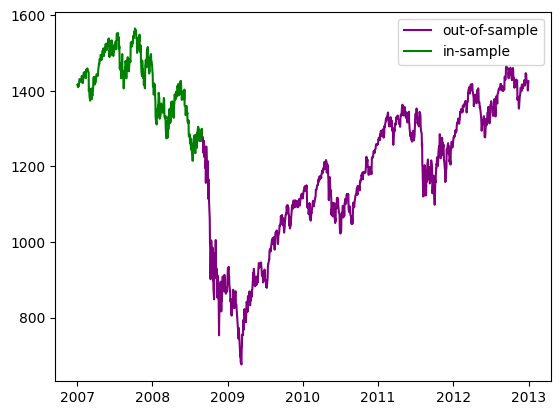

175980 458220


In [5]:
development_dates = unique_dates[unique_dates<=pd.Timestamp(2008,9,1)]
test_dates = unique_dates[~unique_dates.isin(development_dates)]
train_data = dataset[dataset['calculation_date'].isin(development_dates)]
test_data = dataset[dataset['calculation_date'].isin(test_dates)]
train_plot = train_data[['calculation_date','spot_price']].copy().set_index('calculation_date').drop_duplicates()
test_plot = test_data[['calculation_date','spot_price']].copy().set_index('calculation_date').drop_duplicates()
plt.figure()
plt.plot(test_plot,color='purple',label='out-of-sample')
plt.plot(train_plot,color='green',label='in-sample')
plt.legend()
plt.show()
arrs = trainer.get_train_test_arrays(
    train_data, test_data)
preprocessor = trainer.preprocess()
train_X = arrs['train_X'] 
train_y = arrs['train_y']
test_X = arrs['test_X']
test_y = arrs['test_y']
print(len(train_y),len(test_y))

# training

In [6]:
model_fit = trainer.run_dnn(preprocessor,train_X,train_y)
model_fit


training...

alpha: 0.01
hidden_layer_sizes: (15, 15)
learning_rate: adaptive
learning_rate_init: 0.1
solver: sgd
early_stopping: False
max_iter: 500
warm_start: True
tol: 0.0001
cpu: 25.32900047302246


TransformedTargetRegressor(regressor=Pipeline(steps=[('preprocessor',
                                                      ColumnTransformer(transformers=[('StandardScaler',
                                                                                       StandardScaler(),
                                                                                       ['spot_price',
                                                                                        'strike_price',
                                                                                        'days_to_maturity',
                                                                                        'risk_free_rate',
                                                                                        'dividend_rate',
                                                                                        'kappa',
                                                                                        'theta',
                                                                                        'rho',
                                                                                        'eta',
                                                                                        'v0',
                                                                                        'fixing_frequency',
                                                                                        'n_fixings',
                                                                                        'past_fixings']),
                                                                                      ('OneHotEncoder',
                                                                                       OneHotEncoder(sparse_output=False),
                                                                                       ['averaging_type',
                                                                                        'w'])])),
                                                     ('regressor',
                                                      MLPRegressor(alpha=0.01,
                                                                   hidden_layer_sizes=(15,
                                                                                       15),
                                                                   learning_rate='adaptive',
                                                                   learning_rate_init=0.1,
                                                                   max_iter=500,
                                                                   solver='sgd',
                                                                   warm_start=True))]),
                           transformer=Pipeline(steps=[('StandardScaler',
                                                        StandardScaler())]))

# testing

In [7]:
insample, outsample, errors = trainer.test_prediction_accuracy(
        model_fit,
        test_data,
        train_data
)
outofsample_RMSE = errors['outofsample_RMSE']


in sample:
     RMSE: 2.17249925554646
     MAE: 1.227027906903072

out of sample:
     RMSE: 26.65224111736999
     MAE: 7.148486587578028


# saving

In [8]:
train_end = time.time()
train_end_tag = str(datetime.fromtimestamp(
    train_end).strftime("%Y_%m_%d %H%M%S%f"))
file_tag = str(train_end_tag + " " + filetag)
files_dir = os.path.join(models_dir,file_tag)

def save_model():
    if Path(files_dir).exists():
        pass
    else:
        os.mkdir(files_dir)
    file_dir = os.path.join(files_dir,file_tag)
    S = np.sort(train_data['spot_price'].unique())
    K = np.sort(train_data['strike_price'].unique())
    T = np.sort(train_data['days_to_maturity'].unique())
    W = np.sort(train_data['w'].unique())
    n_calls = train_data[train_data['w']=='call'].shape[0]
    n_puts = train_data[train_data['w']=='put'].shape[0]
    insample.to_csv(f"{file_dir} insample.csv")
    outsample.to_csv(f"{file_dir} outsample.csv")
    joblib.dump(model_fit,str(f"{file_dir}.pkl"))
    pd.set_option("display.max_columns",None)
    
    with open(f'{file_dir}.txt', 'w') as file:
        file.write(train_start_tag)
        file.write(f"\nspot(s):\n{S}")
        file.write(f"\n\nstrikes:\n{K}\n")
        file.write(f"\nmaturities:\n{T}\n")
        file.write(f"\ntypes:\n{W}\n")
        try:
            file.write(f"\n{train_data['barrier_type_name'].unique()}")
        except Exception:
            pass
        try:
            for col in ['averaging_type','fixing_frequency','past_fixings','n_fixings']:
                file.write(f"\n{col}:")
                file.write(f"\n{dataset[col].drop_duplicates().sort_values().values}\n")
        except Exception:
            pass
        file.write(f"\nnumber of calls, puts:\n{n_calls},{n_puts}\n")
        file.write(f"\ntotal prices:\n{train_data.shape[0]}\n")

        file.write("#"*17+"\n# training data #\n"+"#"*17+
              f"\n{train_data.describe()}\n")
        file.write("#"*13+"\n# test data #\n"+"#"*13+
              f"\n\n{test_data.describe()}\n")
        file.write(f"\n{dataset.dtypes}")
        file.write(
            f"\nin sample results:"
            f"\n     RMSE: {errors['insample_RMSE']}"
            f"\n     MAE: {errors['insample_MAE']}\n"
            f"\nout of sample results:"
            f"\n     RMSE: {errors['outofsample_RMSE']}"
            f"\n     MAE: {errors['outofsample_MAE']}\n"
            )
        file.write("\nfeatures:\n")
        for feature in trainer.feature_set:
            file.write(f"     {feature}\n")
        file.write(f"\ntarget: {trainer.target_name}\n")
        file.write(f"\ncpu: {train_runtime}\n")
        file.write(datetime.fromtimestamp(train_end).strftime('%c'))
        print(f"model saved to {file_dir}")

print(f"execute the command 'save_model()' to save the following model: {file_tag}")
train_runtime = train_end-train_start
print(f"\ncpu: {train_runtime}")

execute the command 'save_model()' to save the following model: 2024_10_29 122031053637 bloomberg asian options

cpu: 28.395331859588623
